# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.5.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CuArrays"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Installing Julia 1.5.3 on the current Colab Runtime...
2021-02-24 03:27:28 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz [105260711/105260711] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
 Installing known registries into `~/.julia`
######################################################################## 100.0%
      Added registry `General` to `~/.julia/registries/General`
  Resolving package versions...
  Installed ZeroMQ_jll ────── v4.3.2+6
  Installed VersionParsing ── v1.2.0
  Installed libsodium_jll ─── v1.0.18+1
  Installed SoftGlobalScope ─ v1.1.0
  Installed Parsers ───────── v1.0.15
  Installed Conda ─────────── v1.5.0
  Installed IJulia ────────── v1.23.2
  Installed JSON ──────────── v0.21.1
  Installed MbedTLS ───────── v1.0.3
  Installed Artifacts ─────── v1.3.0
  Installed JLLWrappers ───── v1.2.0
  Installed ZMQ ───────────── v1.2.1
  Installed MbedTLS_jll ───── v2.16.8+1
################################

# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

NameError: ignored

Develop and test python code for 12.805 pset6

Tom Farrar
November 12, 2020

Specifically, the goal is to develop functions analogous to the MATLAB ones I provided called centeredFFT.m, band_avg.m, confid.m, and confidence_interval.m.

Ported to Julia, Jake Gebbie, Jan. 20, 2021

In [ ]:
import Pkg; Pkg.add("Distributions");Pkg.add("FFTW")
using Statistics, Plots, Distributions, FFTW


   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
  Installed Rmath_jll ──────── v0.2.2+1
  Installed OpenSpecFun_jll ── v0.5.3+4
  Installed PDMats ─────────── v0.10.1
  Installed Rmath ──────────── v0.6.1
  Installed StatsFuns ──────── v0.9.6
  Installed FillArrays ─────── v0.10.2
  Installed QuadGK ─────────── v2.4.1
  Installed Distributions ──── v0.24.10
  Installed SpecialFunctions ─ v1.2.1
  Installed ChainRulesCore ─── v0.9.26
Updating `~/.julia/environments/v1.5/Project.toml`
  [31c24e10] + Distributions v0.24.10
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [d360d2e6] + ChainRulesCore v0.9.26
  [31c24e10] + Distributions v0.24.10
  [1a297f60] + FillArrays v0.10.2
  [efe28fd5] + OpenSpecFun_jll v0.5.3+4
  [90014a1f] + PDMats v0.10.1
  [1fd47b50] + QuadGK v2.4.1
  [79098fc4] + Rmath v0.6.1
  [f50d1b31] + Rmath_jll v0.2.2+1
  [276daf66] + SpecialFunctions v1.2.1
  [4c63d2b9] + StatsFuns v0.9.6
  [4607b0f0] + SuiteSparse
  Resolving pac

Define some functions to use

In [ ]:
function centeredFFT(x,dt)
#= function centeredFFT(x,dt)

 Computes FFT, with zero frequency in the center, and returns 
  dimensional frequency vector.

 Inputs:
    x, vector to be transformed
    dt, time increment

 Adapted from a function written by Quan Quach of blinkdagger.com 
     Tom Farrar, 2016, jfarrar@whoi.edu
     For Julia, Jake Gebbie, 2021, jgebbie@whoi.edu
    =#
    
    n=length(x)

    #Generate frequency index
    if n%2 == 0
        m=-n/2:n/2-1 # N even
    else
        m=-(n-1)/2:(n-1)/2 # N odd
    end
    freq=m/(n*dt)  #the dimensional frequency scale, this is an "iterator", not a vector, in julia
    
    xhat = fft(x)
    
    xhat = fftshift(xhat) #=swaps the halves of the FFT vector so that 
                           the zero frequency is in the center.
                           If you are going to compute an IFFT, 
                           first use X=ifftshift(X) to undo the shift =#
    return xhat,freq
end

function band_avg(yy,num,dim=missing)
#= band_avg.jl   Block averages for band averaging
 [yy_avg]=band_avg(yy,num,dimension)

 Inputs:
	yy, quantity to be averaged (must be vector or matrix)
	num, number of bands to average
	dimension (optional), dimension to average along; if specified, must be 1 or 2

 Tom Farrar, 2016, jfarrar@whoi.edu
 Ported to Julia, Jake Gebbie, 2021, jgebbie@whoi.edu =#

    numdims = ndims(yy)
    nyy = size(yy)

    if (numdims > 2) error("Dimension must be equal to 1 or 2 for band_avg") end

    # shortcut execution
    if numdims == 1
        # initialize yy_avg
        yy_avg = fill(0,floor(Integer,nyy[1]/num))
        for n = 1:num
            yy_avg += yy[n:num:end-(num-n)]
        end
        
    elseif numdims == 2
        if ismissing(dim) 
            greaterthanone = x -> x>1
            if count(greaterthanone,yy) > 1
                error("Dimension must be specified for 2D input to band_avg")
            else
                dim = findfirst(greaterthanone,yy) 
            end
        end
        if dim==1
            # initialize yy_avg
            nyy_avg = (floor(Integer,nyy[1]/num),nyy[2])
            yy_avg = fill(0,nyy_avg)
            for n=1:num
                yy_avg += yy[n:num:end-(num-n),:]
            end
        elseif dim==2
            #initialize yy_avg
            nyy_avg = (nyy[1],floor(Integer,nyy[2]/num))
            yy_avg = fill(0,nyy)
            for n=1:num
                yy_avg += yy[:,n:num:end-(num-n)]
            end
        end
    end

    # take the average
    yy_avg=yy_avg./num
    
    return yy_avg
end


band_avg (generic function with 2 methods)

Try to test the band-averaging code, which is actually just a bin average

In [ ]:
N  = 20_000 # underscore just for visual appearance
Δt = 1      # could make \Delta in Julia REPL but not in notebook
t  = Δt:Δt:N*Δt
f  = 20/((N-1)*Δt)
noise_val = 0.2 # desired noise std deviation
yb = 1 .+ noise_val.*randn(N) .+ 0.75 .* sin.(2π*f*t)


20000-element Array{Float64,1}:
 1.2108310238793352
 1.3105593987678321
 0.7143085777789122
 1.2134646633394217
 0.8307306644302372
 0.9177092709277193
 1.4810571615903856
 1.0131750758092772
 1.3161392541391326
 1.0683166811378115
 0.8041883669886629
 0.8882963013222289
 0.9728507556080145
 ⋮
 0.7003270167272729
 0.8730600722651786
 1.042786581903788
 1.2780119845892586
 0.8547344061746298
 1.239130227734695
 0.8741842380612848
 1.5096851978408057
 1.0028063815067467
 1.232551803616972
 1.0247035727839005
 0.9602859550802756

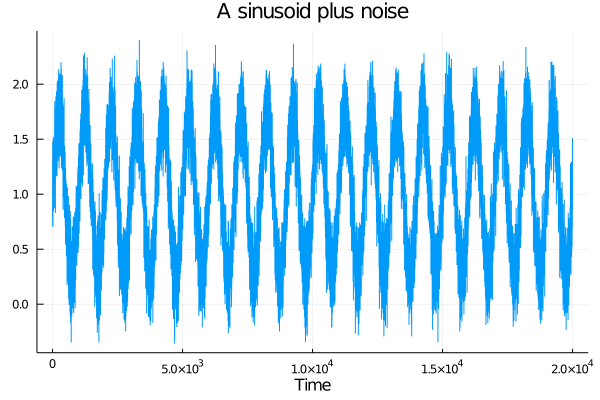

In [ ]:
plot(t,yb, leg=false)
title!("A sinusoid plus noise")
xlabel!("Time")


In [ ]:
navg = 20
y_avg = band_avg(yb,navg)
t_avg = band_avg(t,navg)


1000-element Array{Float64,1}:
    10.5
    30.5
    50.5
    70.5
    90.5
   110.5
   130.5
   150.5
   170.5
   190.5
   210.5
   230.5
   250.5
     ⋮
 19770.5
 19790.5
 19810.5
 19830.5
 19850.5
 19870.5
 19890.5
 19910.5
 19930.5
 19950.5
 19970.5
 19990.5

In [ ]:
size(y_avg) # one more value than Tom's routine (?) 

(1000,)

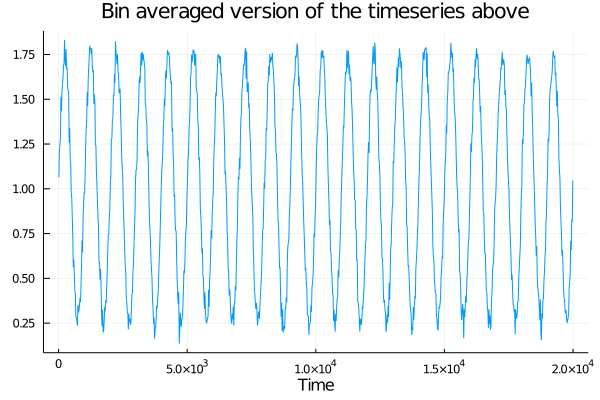

In [ ]:
plot(t_avg,y_avg,leg = false)
title!("Bin averaged version of the timeseries above")
xlabel!("Time")


OK, great! The bin average code seems to work. (We could test this more rigorously, but OK so far.)

OK, now let's try doing a spectrum. First, though, let's recall what we are wanting to do overall. We want to make a function to estimate the band-averaged spectrum and plot it with a 95% confidence interval. To do that, we will follow the steps from Section 4.7.1 of the class notes on spectral analysis:

    Compute the mean of the time series, 𝑥(𝑡)

and subtract it from the time series.
Optional: Taper the record using a taper window, 𝑥𝑡𝑎𝑝𝑒𝑟(𝑡)=𝑤(𝑡)𝑥(𝑡)
. A taper that gives equal weight to most of the record (like a Tukey window) may adequately suppress leakage, if tapering is needed at all. Normalize the taper window such that 1𝑁∑𝑁𝑛=1𝑤2𝑛=1
so that the tapered time series has the same variance as the original one. (As an alternative to the normalizing the window, one could rescale the Fourier coefficients by the square root of the normalization constant, which is equivalent. Some prefer to compute the variance prior to windowing and rescale the spectrum to have that variance, which is also also fine but does not give identical results).
Compute the FFT of the entire tapered record.
Generate a frequency vector, 𝑓𝑚=𝑚/(𝑁Δ𝑡)
with m ranging from −𝑁/2 to 𝑁/2−1 (for even 𝑁
).
Compute the raw, one-sided spectral density and discard frequencies ≤0
.
Band average the raw spectrum over 𝑛𝑑
frequency bands-- this could be done by an algorithm like equation ??? or by computing a running average and subsampling. Generate the new frequency vector, either by subsampling the Fourier frequencies at the interval of 𝑛𝑑/𝑇
or by band averaging the frequency vector.
Estimate a confidence interval (typically a 95% confidence interval). If no taper window was used, 2×𝑛𝑑

    is a good estimate of the number of degrees of freedom. Tapering reduces the number of degrees of freedom because it reduces the linear independence of adjacent frequency bands; if the taper window is modest (uniform weighting over most of the time series), this reduction can be neglected.

Let's try following those steps and then put it together as a function.

    Compute the mean of the time series, 𝑥(𝑡)

and subtract it from the time series.

In [ ]:
yy = yb # just renaming yb to mimic matlab code
N = length(yy)
T = N * Δt
yy .-= mean(yy) # remove the mean


20000-element Array{Float64,1}:
  0.20862754515911197
  0.3083559200476089
 -0.287894900941311
  0.21126118461919852
 -0.17147281428998595
 -0.08449420779250394
  0.4788536828701624
  0.010971597089054042
  0.3139357754189094
  0.06611320241758833
 -0.19801511173156028
 -0.11390717739799427
 -0.029352723112208712
  ⋮
 -0.30187646199295026
 -0.12914340645504463
  0.04058310318356484
  0.2758085058690354
 -0.14746907254559338
  0.23692674901447175
 -0.12801924065893844
  0.5074817191205825
  0.0006029027865235292
  0.23034832489674884
  0.022500094063677256
 -0.04191752363994761


    Optional: Taper the record using a taper window, 𝑥𝑡𝑎𝑝𝑒𝑟(𝑡)=𝑤(𝑡)𝑥(𝑡)

    .

--> Let's skip that for now!


    Compute the FFT of the entire tapered record.



In [ ]:
Y,freq_i = centeredFFT(yy,Δt)


(Complex{Float64}[-3.235181599717377 + 0.0im, -24.494673841086232 - 18.66438970929256im, -17.147716930277674 - 21.766580700794584im, -1.8867512161068971 + 34.151411827981036im, -1.8154015619772683 + 22.681529033542084im, 26.263120339636217 - 3.463464048567296im, -6.415860528112632 - 5.17519558614853im, 7.356591901360321 - 32.88736982308701im, 6.200498823145484 + 1.6073479779050261im, -15.74968142334744 + 4.294317677146012im  …  -4.220816540677566 - 11.783312901490259im, -15.749681423347447 - 4.294317677146006im, 6.200498823145491 - 1.6073479779050204im, 7.356591901360316 + 32.887369823087im, -6.415860528112623 + 5.175195586148527im, 26.263120339636224 + 3.463464048567296im, -1.8154015619772927 - 22.681529033542084im, -1.8867512161068998 - 34.151411827981036im, -17.147716930277674 + 21.7665807007946im, -24.494673841086236 + 18.66438970929257im], -0.5:5.0e-5:0.49995)

Generate a frequency vector, 𝑓𝑚=𝑚/(𝑁Δ𝑡) with m ranging from −𝑁/2 to 𝑁/2−1 (for even 𝑁

    ).

--> This was done by centeredFFT

    Compute the raw, one-sided spectral density and discard frequencies ≤0

    .

--> Nomalization factor should be 2𝑇/𝑁

In [ ]:
ispositive = x -> x > 0
ff = findall(ispositive,freq_i)
Y = Y[ff]
freq_i = freq_i[ff]
Ψraw = (2*T/N^2).*Y.*conj(Y)


9999-element Array{Complex{Float64},1}:
 0.008339908250054064 + 4.336808689942018e-19im
  0.03342599316004158 + 0.0im
  0.15239635804151802 + 0.0im
  0.05784036187517577 + 4.336808689942018e-19im
 0.018683847146554605 + 0.0im
 0.007744594277620539 + 0.0im
 0.010786066724070549 - 1.0842021724855044e-19im
  0.08414465897073453 + 0.0im
    0.207512691785889 + 0.0im
  0.02804031698944035 - 1.734723475976807e-18im
  0.03117626716614448 + 0.0im
  0.01584061703754759 + 8.673617379884035e-19im
 0.021232874821869835 + 0.0im
                      ⋮
 0.021765408441920667 + 0.0im
 0.023480132753714453 + 0.0im
 0.015666175520448414 + 0.0im
 0.026649362924918436 - 8.673617379884035e-19im
 0.004102975317790398 + 2.168404344971009e-19im
  0.11356985382836536 + 0.0im
 0.006794591567108478 + 4.336808689942018e-19im
  0.07017470731899321 + 0.0im
  0.05177474421306421 + 0.0im
  0.11698787599958439 + 8.673617379884035e-19im
  0.07678282313251356 - 6.938893903907228e-18im
  0.09483484898015407 + 0.0im

Band average the raw spectrum over 𝑛𝑑 frequency bands-- this could be done by an algorithm like equation ??? or by computing a running average and subsampling. Generate the new frequency vector, either by subsampling the Fourier frequencies at the interval of 𝑛𝑑/𝑇 or by band averaging the frequency vector.
--> We will use our band-averaging function on both the spectrum and the frequency vector

In [ ]:
M = 11
Ψavg = band_avg(Ψraw,M)
freq = band_avg(freq_i,M)


909-element Array{Float64,1}:
 0.0003
 0.0008500000000000001
 0.0014
 0.0019500000000000001
 0.0025
 0.0030499999999999998
 0.0036000000000000003
 0.00415
 0.0047
 0.00525
 0.0058
 0.00635
 0.006900000000000001
 ⋮
 0.49365000000000003
 0.4942
 0.49475
 0.49529999999999996
 0.49585000000000007
 0.4963999999999999
 0.49694999999999995
 0.4975
 0.49804999999999994
 0.49860000000000004
 0.49915
 0.49970000000000003

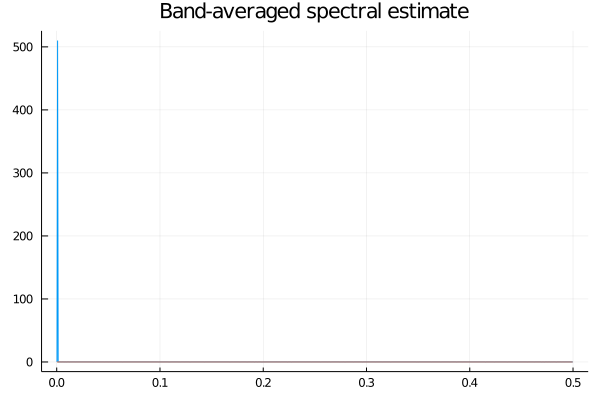

In [ ]:
plot(freq,real(Ψavg),leg=false)
plot!(freq,imag(Ψavg),leg=false)
title!("Band-averaged spectral estimate")


We were expecting the imaginary part to be zero. It appears to be nonzero. This may be a numerical artifact, but let's check this out.


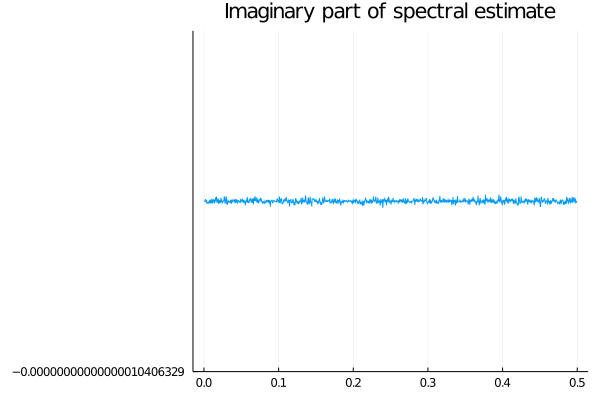

In [ ]:
plot(freq,imag(Ψavg),leg=false)
title!("Imaginary part of spectral estimate")


OK, just as I suspected, the imaginary part is a numerical artifact, close to floating point precision. The best way to handle this in the function we will build would probably be to check if the inputs are real, and, if they are, then just throw away the imaginary part of our spectral estimate. (If the input time series is complex, we should expect some imaginary part in the spectrum.)

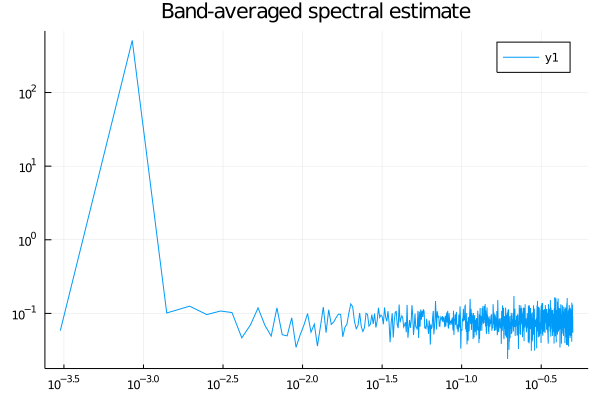

In [ ]:
plot(freq,real(Ψavg), xaxis=:log, yaxis=:log)
title!("Band-averaged spectral estimate")


OK, I need axis labels (and units), but this isn't too terrible.
Try working out confidence limits

In MATLAB, chi2inv(alpha/2,nu) returns 𝜒2𝜈;𝛼/2
. To compute confidence intervals, you simply need to compute the multiplicative factors 𝜈/𝜒2𝜈;𝛼/2 and 𝜈/𝜒2𝜈;1−𝛼/2. Check values (e.g., Jenkins and Watts, 1968, p. 81) are 𝜈/𝜒219;0.025=0.58 and 𝜈/𝜒219;0.975=2.11

(I get 0.5783 and 2.1333 in MATLAB).

It seems that the analogous function in python's scipy.stats module is the "Inverse survival function" (stats.chi2.isf), which is defined as 11−cdf
, where cdf is the cumulative distribution function of the chi-square distribution: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2

In [ ]:
nu = 19 # unicode nu looks like "v" on my computer
α = 0.025
chi = cquantile(Chisq(nu), α) 
nu/chi


0.5783456398680077

In [ ]:
chi = cquantile(Chisq(nu), 1-α) 
nu/chi


2.133269504235972

Great! We are ready to write the function that is analgous to confid.m!

In [ ]:
function confid(α,nu)

    upperv = quantile(Chisq(nu),1-α)
    lowerv = quantile(Chisq(nu),α)
    lower=nu/upperv;
    upper=nu/lowerv;

    return lower, upper

    #=should be sigma^2/S^2 confidence bounds where sigma^2 is true variance
    check value (J&W) is alpha =.05, nu=19, lower bound is .58
    upper bound is 2.11 =#
end



confid (generic function with 1 method)

Check again:


In [ ]:
lower,upper = confid(α,nu)
println(lower)
println(upper)


0.5783456398680077
2.1332695042359724


# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />